# Import Libraries

In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd
import csv
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import pickle
from PIL import ImageOps, Image
import tensorflow as tf
# import tensorflowjs as tfjs
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

2022-04-15 15:15:30.380729: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [52]:
ROUND = 1
EXERCISE = 'squat'
CUR_CLASS = 'out'
PREV_CLASS = 'in'
SUBFIX_VID_NAME = '_hard_vote'
REMOTE = True

In [53]:
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose

# Get all file paths

In [54]:
all_file_paths = []
accepted_exts = ('.jpg', '.jpeg','.png')
if REMOTE:
    walk_path = f'/home/u6188041/jom/Dataset/EzFit_dataset/images/{EXERCISE}'
else:
    walk_path = f'D:\EzFit_dataset\images\{EXERCISE}'
for path, subdirs, files in os.walk(walk_path):
    for name in files:
        if name.lower().endswith(accepted_exts):
            all_file_paths.append(os.path.join(path, name))

In [55]:
# all_file_paths

In [56]:
len(all_file_paths)

738

### We cannot put BlazePose kps extraction into tf.data pipline. Therefore, we need to go for manual way to load data (since we have not that big data, this is possible)

In [57]:
data = []
labels = []

In [58]:
error_files = []
for image_path in tqdm(all_file_paths):
    image = Image.open(image_path)
    image = np.array(image)
    label = image_path.split(os.path.sep)[-2]
    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:

        results = pose.process(image)
        
        try:
            pose_coor = results.pose_landmarks.landmark
            # no need z here
            body_kps = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
            data.append(body_kps)
            labels.append(label)
            
        except:
            error_files.append(image_path)

  0%|                                                                                           | 0/738 [00:00<?, ?it/s]INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
  0%|▏                                                                                  | 2/738 [00:00<01:03, 11.54it/s]INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.
INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.
  1%|▍                                                                                  | 4/738 [00:00<01:06, 11.12it/s]Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yiel

In [59]:
len(error_files),error_files

(21,
 ['/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/12_6_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/102_2_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/56_7_1.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/17_10_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/12_5_1.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/12_3_1.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/17_5_1.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/17_6_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-down/97_1_1.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-up/68_1_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-up/58_3_2.jpg',
  '/home/u6188041/jom/Dataset/EzFit_dataset/images/squat/squat-up/12_6_1.jpg',
  '/home/u6188041/jom/Datas

In [60]:
# all_file_paths = [x for x in all_file_paths if x not in error_files]
# len(all_file_paths)

In [61]:
# # use for label encoder and stratify
# labels = list(map(lambda x: x.split(os.path.sep)[-2], all_file_paths))
# labels

In [62]:
# check balanceness
total = len(labels)
label_count = Counter(labels)
label_count, total

(Counter({'squat-down': 235, 'squat-up': 238, 'others': 244}), 717)

In [35]:
# since we are sure that all files can be extracted by BlazePose
# there is no need for try-except blocks
def extract_body_kps(image):
    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose: 
        results = pose.process(image.numpy())
        pose_coor = results.pose_landmarks.landmark
        # no need z here
        body_kps = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
        return body_kps

In [14]:
def load_and_get_kps(image_path):
    # load image and get kps
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    kps = tf.py_function(extract_body_kps, inp=[image], Tout=[tf.float32])[0]
    
    # parse label
    label_str = tf.strings.split(image_path, os.path.sep)[-2]
    # one-hot (le is defined below)
    label = label_str == le.classes_
    label = tf.cast(label, tf.int32)
    
    return kps, label

# Preprocess

In [15]:
data = np.array(data)

In [16]:
lb = LabelBinarizer()
lb.fit(labels)
encoded_labels = lb.transform(labels)
if len(lb.classes_) == 2:
    encoded_labels = to_categorical(encoded_labels)

In [17]:
encoded_labels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [18]:
# # fit so that we can use le.classes_ in one-hot encoding process in pipeline
# # and stratify
# le = LabelEncoder()
# le.fit(labels)
# encoded_labels = le.transform(labels)
# encoded_labels

In [19]:
lb.classes_

array(['half-burpee-in', 'half-burpee-out', 'others'], dtype='<U15')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=encoded_labels)

In [21]:
X_train.shape, y_train.shape

((666, 99), (666, 3))

In [22]:
X_test.shape, y_test.shape

((75, 99), (75, 3))

# Class weighting
Since we have a bit imbalanced data, so we should do class weighting  
formula derived from here: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights

In [23]:
NUM_CLASSES = len(lb.classes_)
class_weights = {}
for label in label_count:
    class_weights[np.argmax(lb.transform([label])[0])] = (1 / label_count[label]) * (total / NUM_CLASSES)

In [24]:
class_weights

{2: 0.9919678714859437, 0: 1.0291666666666666, 1: 0.9801587301587301}

# Data pipeline
Somehow tf.data load the data forever, so we need to do the manual way

In [25]:
BATCH_SIZE = 32
EPOCHS = 150
NUM_CLASSES = len(lb.classes_)
INIT_LR = 1e-3

In [26]:
# train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
# train_ds = (train_ds
#             .shuffle(len(train_paths), seed=42)
#             .map(load_and_get_kps, num_parallel_calls=AUTOTUNE)
#             .cache()
#             .batch(BATCH_SIZE)
#             .prefetch(AUTOTUNE)
#            )

In [27]:
# test_ds = tf.data.Dataset.from_tensor_slices(test_paths)
# test_ds = (test_ds
#             .map(load_and_get_kps, num_parallel_calls=AUTOTUNE)
#             .cache()
#             .batch(BATCH_SIZE)
#             .prefetch(AUTOTUNE)
#            )

In [28]:
# next(iter(train_ds))

In [29]:
# data = []
# labels = []

In [30]:
# # extract pushup coordinate from images
# # image = cv2.imread('dataset/pushup/pushup-up/pushup-up-2.jpg')
# error_files = []
# for image_path in tqdm(all_file_paths):
    
#     original_image = cv2.imread(image_path)
#     class_name = image_path.split(os.sep)[-2]
    
#     with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose, \
#     mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose2:

#         image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False

#         results = pose.process(image)

#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

#         mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
#                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
#                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
#                                  )

#         try:
#             pose_coor = results.pose_landmarks.landmark
#             # no need z here
#             row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
#             data.append(row)
#             labels.append(class_name)

#         except:
#             error_files.append(image_path)

# #         # augmented version (flip horizontally)
# #         augmented_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
# #         augmented_image = cv2.flip(augmented_image, 1)
# #         augmented_image.flags.writeable = False

# #         augmented_results = pose2.process(augmented_image)

# #         augmented_image.flags.writeable = True
# #         augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)

# #         mp_drawing.draw_landmarks(augmented_image, augmented_results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
# #                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
# #                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
# #                                  )

# #         try:
# #             pose_coor = augmented_results.pose_landmarks.landmark
# #             # no need z here
# #             row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()
# #             row = list(row)
# #             row.insert(0, class_name)

# #             with open('csv/pushup_coords_no_z.csv', 'a', newline = '') as file:
# #                 csv_writer = csv.writer(file, delimiter = ',')
# #                 csv_writer.writerow(row)
# #         except:
# #             error_files.append(image_path + '(augmented)')

# #         cv2.imshow('Push up',image)
# #         cv2.imshow('Augmented Push up', augmented_image)

# #         cv2.waitKey(0)
# #         cv2.destroyAllWindows()

In [31]:
# error_files

# Model training

In [32]:
# tf.keras.backend.clear_session()

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(99,), dtype=tf.dtypes.float32),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

2022-04-12 10:18:26.519668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 10:18:26.568583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 10:18:26.569105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-04-12 10:18:26.569122: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 10:18:26.570449: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-12 10:18:26.570478: I tensorflow/stream_executor/plat

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25600     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 9

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

In [37]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(X_train,
         y_train,
         epochs=EPOCHS,
         validation_data=(X_test, y_test),
         callbacks=[early_stopping],
         class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-04-12 10:18:27.019938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-12 10:18:27.020308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3499880000 Hz


Epoch 1/150


2022-04-12 10:18:27.310047: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


21/21 [==============================] - 1s 7ms/step - loss: 1.0770 - accuracy: 0.3934 - val_loss: 1.0119 - val_accuracy: 0.5067
Epoch 2/150
 1/21 [>.............................] - ETA: 0s - loss: 1.0972 - accuracy: 0.3438

2022-04-12 10:18:27.595243: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


21/21 [==============================] - 0s 3ms/step - loss: 0.9408 - accuracy: 0.5526 - val_loss: 0.8663 - val_accuracy: 0.6000
Epoch 3/150
21/21 [==============================] - 0s 2ms/step - loss: 0.8280 - accuracy: 0.5946 - val_loss: 0.7578 - val_accuracy: 0.6800
Epoch 4/150
21/21 [==============================] - 0s 3ms/step - loss: 0.7208 - accuracy: 0.6742 - val_loss: 0.6795 - val_accuracy: 0.6000
Epoch 5/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.7087 - val_loss: 0.6697 - val_accuracy: 0.7467
Epoch 6/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.7057 - val_loss: 0.6221 - val_accuracy: 0.7467
Epoch 7/150
21/21 [==============================] - 0s 3ms/step - loss: 0.5861 - accuracy: 0.7387 - val_loss: 0.5893 - val_accuracy: 0.7200
Epoch 8/150
21/21 [==============================] - 0s 3ms/step - loss: 0.5175 - accuracy: 0.7763 - val_loss: 0.6610 - val_accuracy: 0.7067
Epoch 9/150
21/21 [======

# Setup all dirs
*Note:* You have to create visualization dir at the bottom most manually

In [39]:
import os

In [40]:
all_dirs = []
model_dir = f'saved_models/round_{ROUND}/{EXERCISE}/'
all_dirs.append(model_dir)
pickle_dir = f'saved_pickles/round_{ROUND}/{EXERCISE}/'
all_dirs.append(pickle_dir)
output_vid_dir = f'output_videos/round_{ROUND}/{EXERCISE}/'
all_dirs.append(output_vid_dir)

In [41]:
for d in all_dirs:
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

# Save model

In [42]:
model.save(os.path.join(model_dir, f'{EXERCISE}_kps_single.h5'), save_format='h5')

In [43]:
# serialize lb
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_single_lb.pickle'), 'wb') as file:
    pickle.dump(lb, file)

# Evaluate the model

In [44]:
raw_preds_y = model.predict(X_test)
raw_preds_y

array([[9.89811718e-01, 1.00249927e-02, 1.63256787e-04],
       [9.92704145e-07, 2.29041558e-02, 9.77094769e-01],
       [1.12900115e-03, 9.87441301e-01, 1.14297923e-02],
       [3.45753971e-03, 9.77268517e-01, 1.92739628e-02],
       [1.54454559e-01, 8.39837551e-01, 5.70792984e-03],
       [9.96174276e-01, 3.79729015e-03, 2.84915368e-05],
       [9.38618730e-04, 9.56018925e-01, 4.30424772e-02],
       [1.75830181e-04, 2.44820192e-01, 7.55003989e-01],
       [3.41997556e-02, 9.36909318e-01, 2.88909674e-02],
       [9.93287941e-09, 1.17579894e-03, 9.98824179e-01],
       [5.41702937e-03, 7.95561850e-01, 1.99021041e-01],
       [9.97570813e-01, 2.42229225e-03, 6.89285434e-06],
       [2.01231472e-07, 8.50079232e-06, 9.99991298e-01],
       [5.54128829e-03, 9.85098124e-01, 9.36055463e-03],
       [9.91671979e-01, 8.30165111e-03, 2.63681140e-05],
       [9.96584415e-01, 3.40265431e-03, 1.29112241e-05],
       [7.74849176e-01, 2.16065899e-01, 9.08485893e-03],
       [9.81716096e-01, 1.81772

In [45]:
# convert prediction result to one-hot so that we can use inverse_transform of lb
preds_y = np.equal(raw_preds_y, np.max(raw_preds_y, axis=1, keepdims=True)).astype(np.int)
preds_y

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1,

In [46]:
test_y_text = lb.inverse_transform(y_test)
preds_y_text = lb.inverse_transform(preds_y)

### Accuracy

In [47]:
_, acc = model.evaluate(X_test, y_test)
print('Test accuracy:', acc)

3/3 [==============================] - 0s 1ms/step - loss: 0.2104 - accuracy: 0.9333
Test accuracy: 0.9333333373069763


### Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [49]:
cm = confusion_matrix(test_y_text, preds_y_text, labels=lb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lb.classes_)

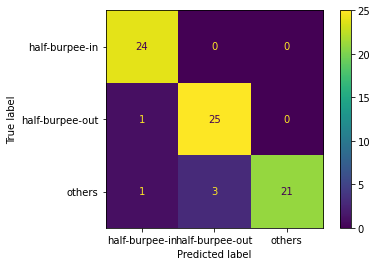

In [50]:
disp.plot()
plt.savefig(f'saved_artifacts/conf_matrix/final/{EXERCISE}/kps_single_cm.png', dpi=300)
plt.show()

Investigate data | Too short seq len?

### ROC AUC

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_test, raw_preds_y)

0.9812870618332803

# Detect in realtime

In [53]:
loaded_model = tf.keras.models.load_model(os.path.join(model_dir, f'{EXERCISE}_kps_single.h5'))

In [54]:
loaded_model.inputs

[<KerasTensor: shape=(None, 99) dtype=float32 (created by layer 'input_1')>]

In [55]:
loaded_model.outputs

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_5')>]

In [56]:
# tfjs.converters.save_keras_model(loaded_model, 'models/tfjs_models/RepCount_Pushup')

# Make detection with model

In [57]:
# serialize model and le
with open(os.path.join(pickle_dir, f'{EXERCISE}_kps_single_lb.pickle'), 'rb') as file:
    loaded_lb = pickle.load(file)

In [58]:
from collections import deque, Counter

In [59]:
NUM_TEST_VIDS = 3
for i in range(1, 1+NUM_TEST_VIDS):
    rep_count = 0
    preds_window = deque(maxlen=15)
    current_stage = None
    previous_stage = None
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    video_writer = cv2.VideoWriter(os.path.join(output_vid_dir, f'{EXERCISE}_{i}_kps_single{SUBFIX_VID_NAME}.avi'), cv2.VideoWriter_fourcc(*'MJPG'),
                                   25, video_size)

    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()

                y_hat = loaded_model.predict(tf.expand_dims(pose_row, axis=0))[0]
                y_idx = np.argmax(y_hat)
                
                if 'hard_vote' in SUBFIX_VID_NAME:
                    # do hard voting
                    preds_window.append(y_idx)
                    pred_count = Counter(preds_window)
                    # most_common return .items() format
                    # ex. [(0,5), (1,3)]
                    voted_pred = pred_count.most_common(1)[0][0]
                    class_name = loaded_lb.classes_[voted_pred]
                else:
                    class_name = loaded_lb.classes_[y_idx]
                
                prob = np.max(y_hat)
                print(y_hat, class_name, prob, end='\r')

                # count the rep logic
                current_stage = class_name

                if current_stage == f'{EXERCISE}-{CUR_CLASS}' and previous_stage == f'{EXERCISE}-{PREV_CLASS}':
                    rep_count += 1

                previous_stage = current_stage

                print('rep:',rep_count, end='\r')

    #             image = cv2.resize(image, (640, 368))
                    
                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

                # display rep count
                cv2.putText(image, 'Rep', (640-52, 0+15),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(rep_count), (640-52, 0+50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255,255,255), 2, cv2.LINE_AA)

            except Exception as e:
                print('[INFO] error:', e)
            
            video_writer.write(image)
            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        cap.release()
        video_writer.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'66966687865225
[INFO] error: 'NoneType' object has no attribute 'landmark'


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'75
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'3
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'4
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has 

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'4.91780335
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'44836
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' 

# Save class for visualization

In [60]:
NUM_TEST_VIDS = 3
for i in range(1, 1+NUM_TEST_VIDS):
    predicted_class = []
    preds_window = deque(maxlen=15)
    cap = cv2.VideoCapture(f'objective_test_videos/{EXERCISE}/{EXERCISE}_{i}.mp4')
    total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # video_width = int(cap.get(3))
    # video_height = int(cap.get(4))
    # video_size = (video_width, video_height)
    video_size = (640, 360)
    
    with mp_pose.Pose(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (640, 360))

            image.flags.writeable = False

            results = pose.process(image)

            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Pose Detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                     mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                     mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                                     )

            # append face&body coordinates for each frame to the csv file to create dataset to train the model
            try:
                # extract pose
                pose_coor = results.pose_landmarks.landmark
                pose_row = np.array([[landmark.x, landmark.y, landmark.visibility] for landmark in pose_coor]).flatten()

                y_hat = loaded_model.predict(tf.expand_dims(pose_row, axis=0))[0]
                y_idx = np.argmax(y_hat)
                
                if 'hard_vote' in SUBFIX_VID_NAME:
                    # do hard voting
                    preds_window.append(y_idx)
                    pred_count = Counter(preds_window)
                    # most_common return .items() format
                    # ex. [(0,5), (1,3)]
                    voted_pred = pred_count.most_common(1)[0][0]
                    class_name = loaded_lb.classes_[voted_pred]
                    predicted_class.append(voted_pred)
                else:
                    class_name = loaded_lb.classes_[y_idx]
                    predicted_class.append(y_idx)
                
                prob = np.max(y_hat)
                print(y_hat, class_name, prob, end='\r')

                # status box at top left corner
                cv2.rectangle(image, (0,0), (320,60), (245,117,16), -1)

                # display class
                cv2.putText(image, 'Class', (95, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (95, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # display prob
                cv2.putText(image, 'Prob', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(np.max(prob),2)), (10, 40),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

                # rep count box at top right corner
                cv2.rectangle(image, (580, 60), (640, 0), (245,117,16), -1)

            except Exception as e:
                predicted_class.append(0)
                print('[INFO] error:', e)

            if not REMOTE:
                cv2.imshow(f'{EXERCISE} Count Detection', image)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        assert len(predicted_class) == total_frame, f"# of label {len(predicted_class)} != # of frames in the video {total_frame}"
                    
        temp_save_path = f'saved_pickles/for_visualization/{EXERCISE}/test_vid_{i}/round_{ROUND}'
        if not os.path.exists(temp_save_path):
            os.makedirs(temp_save_path, exist_ok=True)
        with open(os.path.join(temp_save_path, f'test_vid_{i}_kps_single{SUBFIX_VID_NAME}.pickle'), 'wb') as f:
            pickle.dump(predicted_class, f)
        cap.release()
        if not REMOTE:
            cv2.destroyAllWindows()

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'75
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'3
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'4
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has 

INFO: Replacing 223 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 6 partitions.
INFO: Replacing 318 node(s) with delegate (TfLiteXNNPackDelegate) node, yielding 1 partitions.


[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'4.91780335
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'
[INFO] error: 'NoneType' object has no attribute 'landmark'44836
[INFO] error: 'NoneType' 